In [ ]:
%pip install numpy matplotlib pennylane

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QuantumPhaseEstimation
from pennylane import numpy as np

Normalized Solution State Amplitudes:  [ 0.98058068 -0.19611614]
Scaling Factor:  1.699673171197595
Classical Solution:  [ 1.66666667 -0.33333333]
Quantum Solution:  [ 1.66666667 -0.33333333]

Solution State Amplitudes:  [ 0.5270462766947295 -0.10540925533894592 ]
Solution Ratio: 1: 24.999999999999986
Probability Amplitudes after measuring only input and ancilla registers: 
 [0.35555556 0.27777778 0.35555556 0.01111111]


(<Figure size 1400x500 with 1 Axes>, <Axes: >)

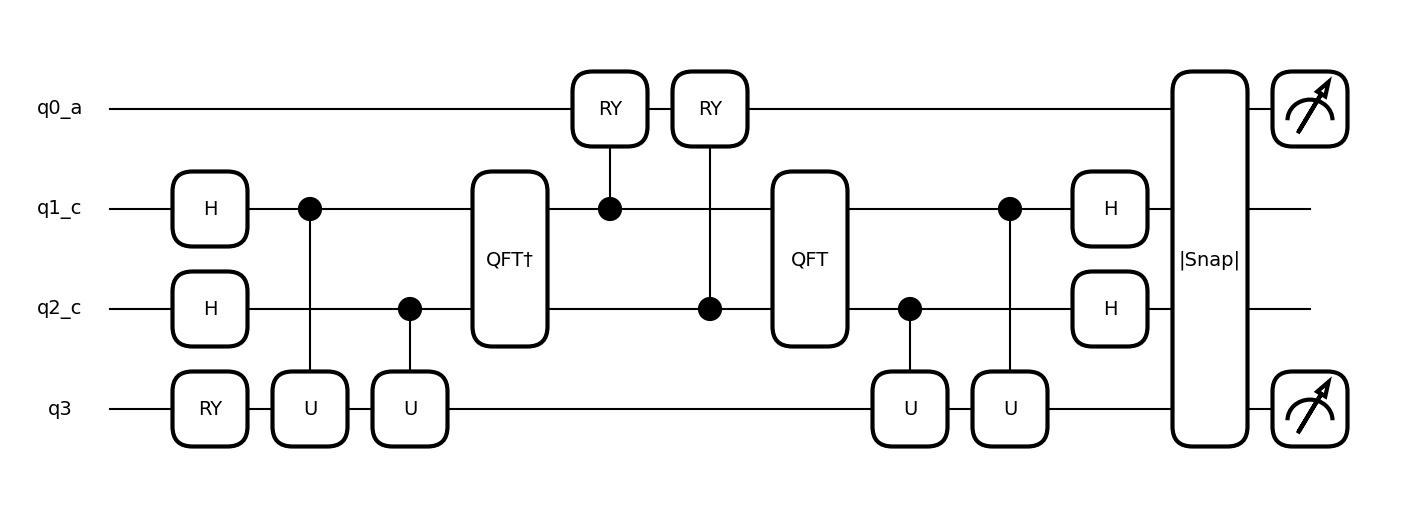

In [29]:
# Given vector, b and Hermitian matrix A
A = np.array([[1, 1/2], [1/2, 1]])
b = np.array([3/2, 1/2])
x_classical = np.linalg.solve(A,b)
b = b / np.linalg.norm(b)



U = (np.array([[0, -1j],[-1j, 0]]))
U_2 = np.array([[-1, 0], [0, -1]])

U_inv =  (np.array([[0, 1j],[1j, 0]]))
U_inv_2 = np.array([[-1, 0], [0, -1]])

theta = 2 * np.arccos(b[0])
# Define the quantum device
num_wires = 4
dev = qml.device("default.qubit")
ancilla_wire = 'q0_a'
clock_wires = ['q1_c','q2_c']
input_wire = 'q3'
t = np.pi   # You can set t to any value

dev = qml.device("default.qubit")
ancilla_wire = 'q0_a'
clock_wires = ['q1_c','q2_c']
input_wire = 'q3'


@qml.qnode(dev)
def circuit(ancilla_wire, clock_wires, input_wire):
    # State preparation
    qml.RY(theta, wires=input_wire)

    # QPE
    for w in clock_wires:
        qml.Hadamard(w)
    qml.ControlledQubitUnitary(U_2, control_wires=clock_wires[0], wires=input_wire)
    qml.ControlledQubitUnitary(U, control_wires=clock_wires[1], wires=input_wire)
    qml.adjoint(qml.QFT)(wires = clock_wires)

    # RY
    qml.CRY(2*np.arcsin(1/3)- np.pi, wires=[clock_wires[0], ancilla_wire])
    qml.CRY(np.pi , wires=[clock_wires[1], ancilla_wire])

    # Inverse QPE
    qml.QFT(wires=clock_wires)
    qml.ControlledQubitUnitary(U_inv, control_wires=clock_wires[1], wires=input_wire)
    qml.ControlledQubitUnitary(U_inv_2, control_wires=clock_wires[0], wires=input_wire)
    for w in clock_wires:
        qml.Hadamard(w)

    qml.Snapshot("final state")

    return qml.probs([input_wire, ancilla_wire])

# Variables that stores the probability amplitudes of the measured circuit and another variable to store the state of the circuit before final measurement
result = circuit(ancilla_wire, clock_wires, input_wire)
states = (qml.snapshots(circuit))(ancilla_wire, clock_wires, input_wire)

# Retrieving the unnormalized |x> solution vector
state_vector = np.array([states['final state'][1].real, states['final state'][9].real])
state_vector = state_vector/np.linalg.norm(state_vector)
print('Normalized Solution State Amplitudes: ', state_vector)

scale = (3/2) / (state_vector[0] + 0.5*state_vector[1])
print('Scaling Factor: ', scale)
x_quantum = scale * state_vector

print('Classical Solution: ', x_classical)
print('Quantum Solution: ', x_quantum)

print('\nUnnormalized Solution State Amplitudes: ', '[',states['final state'][1].real, states['final state'][9].real,']')
print('Solution Ratio: 1:',states['final state'][1].real**2/states['final state'][9].real**2)
print('Probability Amplitudes after measuring only input and ancilla registers: \n',result)



qml.draw_mpl(circuit, show_all_wires=True)(ancilla_wire, clock_wires, input_wire)

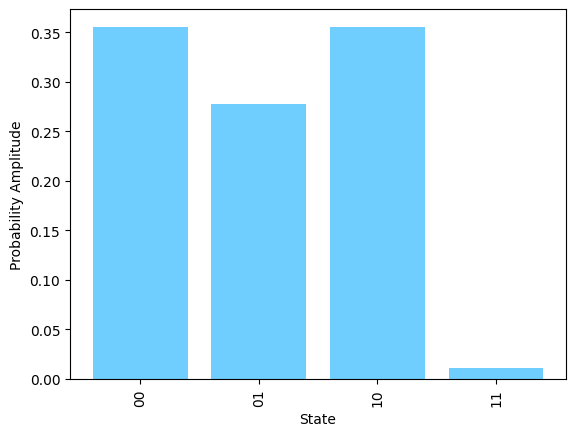

In [116]:
bit_strings = [f"{x:0{2}b}" for x in range(len(result))]

plt.bar(bit_strings, result, color="#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State")
plt.ylabel("Probability Amplitude")
plt.show()